### Quickstart example using FashionMNIST

Link: https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

In [17]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

In [2]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [31]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

In [49]:
def show_network_output(X, Y, Y_pred, num_samples):
    for i in range(num_samples):
        x = X[i, 0].numpy()
        y = Y[i].item()
        y_pred = Y_pred[i].item()

        if y == y_pred:
            continue

        print(f"GT: {classes[y]}, Pred: {classes[y_pred]}")
        plt.figure(figsize=(3, 3))
        plt.imshow(x, cmap='gray')
        plt.show()
        

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
Class: Ankle boot


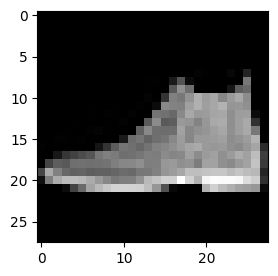

Class: Pullover


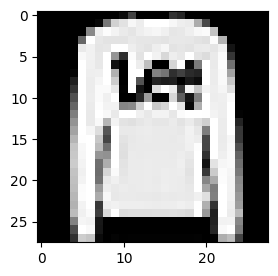

Class: Trouser


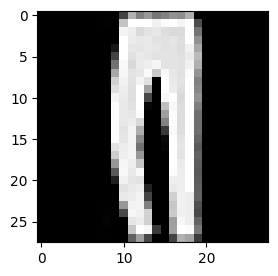

Class: Trouser


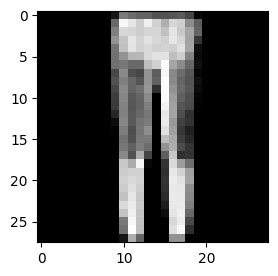

Class: Shirt


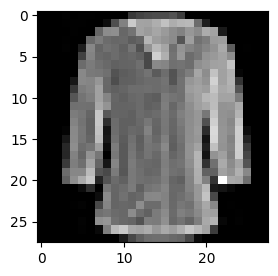

In [33]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, Y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {Y.shape} {Y.dtype}")

    for i in range(5):
        y = Y[i].item()
        
        print(f"Class: {classes[y]}")
        plt.figure(figsize=(3, 3))
        plt.imshow(X[i, 0].numpy(), cmap='gray')
        plt.show()

    break

In [4]:
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device=device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [8]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # compute error
        pred = model(X)
        loss = loss_fn(pred, y)

        # backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [9]:
epochs = 5

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)

print("Done!")

Epoch 1
-------------------------------
loss: 2.288256  [   64/60000]
loss: 2.282812  [ 6464/60000]
loss: 2.259677  [12864/60000]
loss: 2.258806  [19264/60000]
loss: 2.246861  [25664/60000]
loss: 2.207805  [32064/60000]
loss: 2.213204  [38464/60000]
loss: 2.172545  [44864/60000]
loss: 2.179962  [51264/60000]
loss: 2.144561  [57664/60000]
Test Error: 
 Accuracy: 52.1%, Avg loss: 2.138579 

Epoch 2
-------------------------------
loss: 2.142224  [   64/60000]
loss: 2.140837  [ 6464/60000]
loss: 2.077591  [12864/60000]
loss: 2.099136  [19264/60000]
loss: 2.053186  [25664/60000]
loss: 1.983278  [32064/60000]
loss: 2.016736  [38464/60000]
loss: 1.927869  [44864/60000]
loss: 1.947046  [51264/60000]
loss: 1.870384  [57664/60000]
Test Error: 
 Accuracy: 59.6%, Avg loss: 1.865939 

Epoch 3
-------------------------------
loss: 1.894893  [   64/60000]
loss: 1.871397  [ 6464/60000]
loss: 1.748298  [12864/60000]
loss: 1.791957  [19264/60000]
loss: 1.682429  [25664/60000]
loss: 1.633663  [32064/600

In [10]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [11]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [15]:
model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


In [ ]:
with torch.no_grad():
    for X, Y in test_dataloader:
        X = X.to(device)
        pred = model(X)

        Y_pred = pred.argmax(1)

        show_network_output(X.cpu(), Y, Y_pred, 10)

        print(X.shape, Y.shape, Y_pred.shape)